In [188]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import gym
from random import shuffle
from collections import deque
plt.style.use('seaborn')

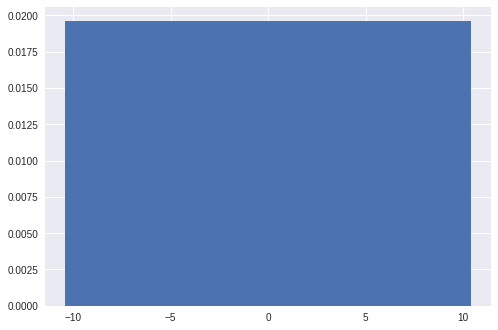

In [30]:
v_min, v_max = -10.0, 10.0
n_support = 51

support = np.linspace(v_min, v_max, n_support)

probs = np.ones(n_support)
probs = probs / sum(probs)

z3 = torch.from_numpy(probs).float()

plt.bar(support, probs);

In [39]:
def update_distn(reward, support, probs, limits = (-10.0, 10.0), discount = 0.8):
    n_support = len(probs)
    v_min, v_max = limits[0], limits[1]
    stride = (v_max - v_min) / (n_support - 1.0)
    i_reward = np.round((reward - v_min) / stride)
    i_reward = int(np.clip(i_reward, 0, n_support - 1))
    probs_new = probs.clone()
    offset = 1
    # Left neighbours
    for i in range(i_reward, 1, -1):
        probs_new[i] += discount**offset * probs_new[i - 1]
        offset += 1
    offset = 1
    # Right neighbours
    for i in range(i_reward, n_support -1, 1):
        probs_new[i] += discount**offset * probs_new[i + 1]
        offset += 1
    probs_new = probs_new / sum(probs_new)
    return probs_new

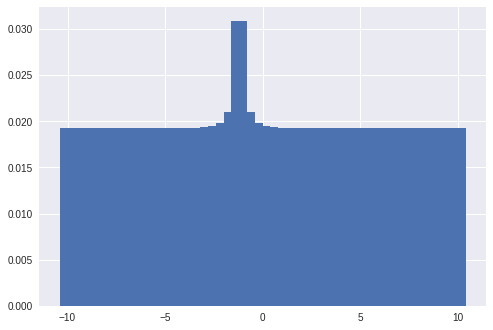

In [40]:
reward = -1

Z = torch.from_numpy(probs)
Z = update_distn(reward, torch.from_numpy(support), Z, limits = (v_min, v_max), discount = 0.3)

plt.bar(support, Z);

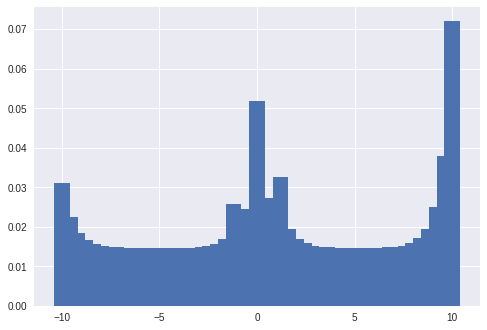

In [41]:
rewards = [10, 10, 10, 0, 1, 0, -10, -10, 10, 10]

for rew in rewards:
    Z = update_distn(rew, torch.from_numpy(support), Z, limits = (v_min, v_max), discount = 0.5)
    
plt.bar(support, Z);

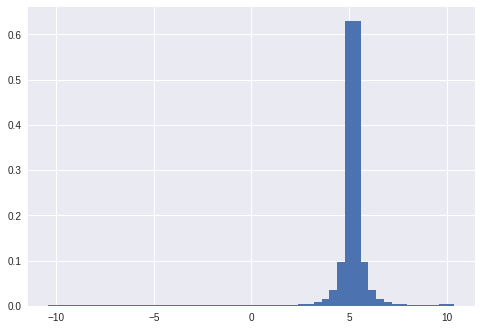

In [42]:
rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

for rew in rewards:
    Z = update_distn(rew, torch.from_numpy(support), Z, limits = (v_min, v_max), discount = 0.7)
    
plt.bar(support, Z);

In [151]:
def distn_dqn(x, params, action_space = 3):
    dim_0, dim_1, dim_2, dim_3 = 128, 100, 25, 51
    i_1 = dim_0 * dim_1
    i_2 = dim_2 * dim_1
    params_1 = params[0:i_1].reshape(dim_0, dim_1)
    params_2 = params[i_1:(i_1 + i_2)].reshape(dim_1, dim_2)
    x = x @ params_1
    x = torch.selu(x)
    x = x @ params_2
    x = torch.selu(x)
    y = []
    for i_action in range(action_space):
        step = dim_2 * dim_3
        i_3 = i_1 + i_2 + (i_action * step)
        params_3 = params[i_3:(i_3 + step)].reshape(dim_2, dim_3)
        x_ = x @ params_3
        y.append(x_)
    y = torch.stack(y, dim = 1)
    y = softmax(y, dim = 2)
    y = y.squeeze()
    return y

def get_target_distn(distn_batch, action_batch, reward_batch, support, limits = (-10, 10), discount = 0.8):
    n_support = len(support)
    v_min, v_max = limits[0], limits[1]
    stride = (v_max - v_min) / (n_support - 1)
    target_distn_batch = distn_batch.clone()
    for i_row in range(distn_batch.shape[0]):
        actions_distn = distn_batch[i_row]
        i_action = int(action_batch[i_row].item())
        distn = actions_distn[i_action]
        reward = reward_batch[i_row]
        if reward != -1:
            target_distn = torch.zeros(n_support)
            i_reward = np.round((reward - v_min) / stride)
            i_reward = int(np.clip(i_reward, 0, n_support - 1))
            target_distn[i_reward] = 1
        else:
            target_distn = update_distn(reward, support, distn, limits = limits, discount = discount)
        target_distn_batch[i_row, i_action, :] = target_distn
    return target_distn_batch

def cross_entropy(y_pred, y_true):
    loss = torch.Tensor([0.0])
    loss.requires_grad = True
    for i_row in range(y_pred.shape[0]):
        loss_ = -1 * torch.log(y_pred[i_row].flatten(start_dim = 0)) @ y_true[i_row].flatten(start_dim = 0)
        loss = loss + loss_
    return loss

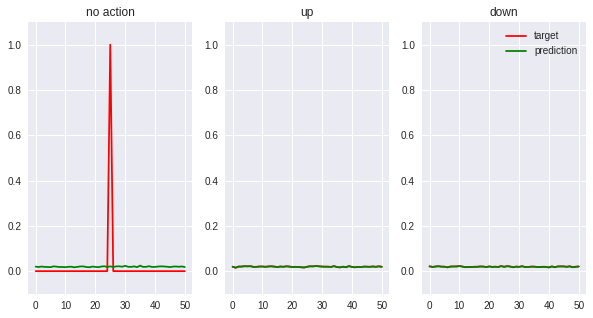

In [152]:
actions = ['no action', 'up', 'down']
action_space = 3
num_params = 128*100 + 25*100 + action_space*25*51
params = torch.randn(num_params) / 10.0
params.requires_grad = True
params_target = params.detach().clone()
v_min, v_max = -10.0, 10.0
discount = 0.9

support = torch.linspace(-10, 10, 51)
state = torch.randn(2, 128) / 10.0
action_batch = torch.Tensor([0, 2])
reward_batch = torch.Tensor([0, 10])

pred_batch = distn_dqn(state, params, action_space = action_space)
target_distn = get_target_distn(
    pred_batch,
    action_batch,
    reward_batch,
    support,
    limits = (v_min, v_max),
    discount = discount
)

fig = plt.figure(figsize = (10, 5))
for i in range(action_space):
    plt.subplot(1, 3, i+1)
    plt.plot(target_distn.flatten(start_dim = 1)[0].data.numpy()[i*51:(i+1)*51], color = 'r', label = 'target')
    plt.plot(pred_batch.flatten(start_dim = 1)[0].data.numpy()[i*51:(i+1)*51], color = 'g', label = 'prediction')
    plt.ylim(-0.1, 1.1)
    plt.xticks(list(range(0, 51, 10)))
    plt.title(actions[i])
plt.legend();

In [153]:
lr = 1e-5
sync_rate = 75
losses = []
num_epochs = 1_000

for i_epoch in range(num_epochs):
    reward_batch = torch.tensor([0, 8]) + (torch.randn(2) / 10.0)
    # Predict with main model
    pred_batch = distn_dqn(state, params, action_space = action_space)
    # Predict with target network
    pred_batch_target = distn_dqn(state, params_target, action_space = action_space)
    # Create target distribution with target network predictions
    target_distn = get_target_distn(
        pred_batch_target,
        action_batch,
        reward_batch,
        support,
        limits = (v_min, v_max),
        discount = discount
    )
    # Compute loss between main model predictions and target distribution
    loss = cross_entropy(pred_batch, target_distn.detach())
    losses.append(loss.item())
    loss.backward()
    with torch.no_grad():
        params -= lr * params.grad
    params.requires_grad = True 
    # Sync target network parameters
    if i_epoch % sync_rate == 0:
        params_target = params.detach().clone()
    # Print progress
    if i_epoch % 100 == 0:
        print(f'Epoch: {i_epoch:04d} | loss: {np.mean(losses[-100:]):.2f}')

Epoch: 0000 | loss: 23.33
Epoch: 0100 | loss: 23.27
Epoch: 0200 | loss: 22.79
Epoch: 0300 | loss: 21.69
Epoch: 0400 | loss: 19.11
Epoch: 0500 | loss: 16.61
Epoch: 0600 | loss: 15.08
Epoch: 0700 | loss: 13.26
Epoch: 0800 | loss: 13.49
Epoch: 0900 | loss: 16.40


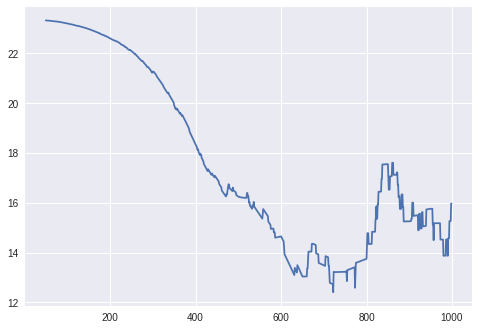

In [154]:
losses = pd.Series(losses).rolling(50).mean()

plt.plot(losses);

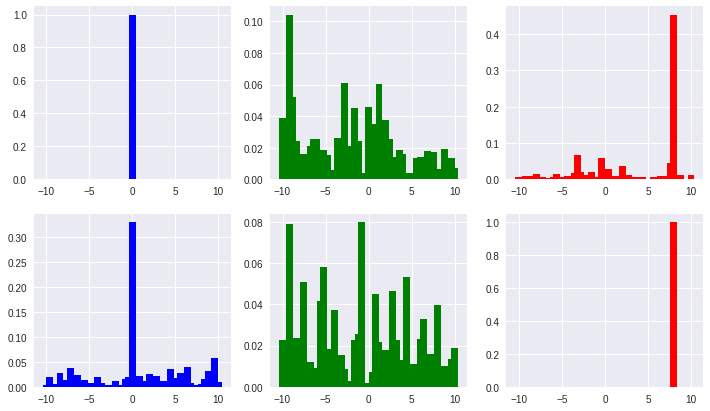

In [162]:
colors = ['blue', 'green', 'red']
fig = plt.figure(figsize = (12, 7))
i_plot = 0
for i_row in range(2): 
    for i_col in range(pred_batch.shape[1]):
        plt.subplot(2, 3, i_plot+1)
        i_plot += 1
        plt.bar(support.data.numpy(), pred_batch[i_row, i_col, :].data.numpy(), color = colors[i_col])

## Atari Freeway

In [191]:
def preprocess_state(state):
    state_ = torch.from_numpy(state).unsqueeze(dim = 0).float()
    state_ = torch.nn.functional.normalize(state_, dim = 1)
    return state_

def get_action(distn, support):
    actions = []
    for i_row in range(distn.shape[0]):
        exp = [support @ distn[i_row, i_action, :] for i_action in range(distn.shape[1])]
        action = int(np.argmax(exp))
        actions.append(action)
    actions = torch.tensor(actions).int()
    return actions

def render_state_and_distn(env, distn, support, shape = (105, 80, 3)):
    """
    Renders a side-by-side image (array) of the current environment state
    next to the current predicted probability distribution over rewards.
    
    Input:
    `env`: OpenAI Gym instantiated environment object
    `distn`: A x 51 tensor , where `A` is action space dimension
    `support`: vector of supports
    `shape`: (w, h, ch) desired output image size
    
    Output:
    - numpy array of RGB image (w, h, ch)
    """
    cs = ['cyan','yellow','red','green','magenta']
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(5,5)
    for i in range(dist.shape[0]): #loop through actions
        _ = ax.bar(support.data.numpy(),dist[i,:].data.numpy(),\
                label='{}'.format(env.env.get_action_meanings()[i]),alpha=0.9,color=cs[i])
    ax.get_yaxis().set_visible(False)
    support_ = np.linspace(support.min(),support.max(),5)
    ax.set_xticks(support_)
    ax.set_xticklabels(support_)
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='x', colors='white')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.legend(loc='upper left',prop={'size': 20})
    plt.close(fig)
    width, height = fig.get_size_inches() * fig.get_dpi()
    width,height=int(width),int(height)
    fig.canvas.draw()
    image1 = np.fromstring(fig.canvas.tostring_rgb(), sep='', dtype='uint8').reshape(height,width,3)
    image2 = resize(image1,shape)
    image2 = img_as_ubyte(image2)
    state_render = img_as_ubyte(resize(env.render('rgb_array'),shape))
    image3 = np.hstack((state_render,image2))
    return image3

In [192]:
env = gym.make('Freeway-ram-v0')

action_space = 3
v_min,v_max = -10, 10
replay_size = 200
batch_size = 50
n_support = 51
stride_support = (v_max - v_min) / (n_support - 1)
support = torch.linspace(v_min, v_max, n_support)
replay = deque(maxlen = replay_size)

lr = 1e-4
discount = 0.1  
num_epochs = 1_300
epsilon = 0.20 # epsilon-greedy policy
epsilon_min = 0.05 
duplication_rate = 5 # prioritized replay
sync_rate = 25 # target network


num_params = 128*100 + 25*100 + action_space*25*51
params = torch.randn(num_params) / 10.0 # random initialization 
params.requires_grad = True
params_target = params.detach().clone() 

losses = []
cum_rewards = []
renders = []
state = preprocess_state(env.reset())

env.get_action_meanings()

['NOOP', 'UP', 'DOWN']

In [195]:
for i_epoch in range(num_epochs):
    preds = distn_dqn(state, params, action_space = action_space)
    # Epsilon greedy
    if i_epoch < replay_size or np.random.rand(1) < epsilon: 
        action = np.random.randint(action_space)
    else:
        action = get_action(preds.unsqueeze(dim = 0).detach(), support).item()
    # Take action
    state_new, reward, finished, _ = env.step(action)
    state_new = preprocess_state(state_new)
    # Save reward
    if reward == 1:
        cum_rewards.append(1) 
    # Adjust rewards to facilitate learning
    if reward == 1:
        reward = 10
    elif reward == 0:
        reward = -1
    elif finished == True:
        reward = -10
    # Save rendered image of game
    if i_epoch % 5 == 0:
        img = render_state_and_distn(env, preds, support)
        renders.append(img)
    # Save experience (s, a, r, s')
    exp = (state, action, reward, state_new)
    replay.append(exp)
    # Prioritized replay
    if reward == 10:
        for i in range(duplication_rate):
            replay.append(exp)
    shuffle(replay)
    # Update state
    state = state_new
    # Experience replay
    if len(replay) == replay_size: 
        indices = np.random.randint(0, len(replay), size = batch_size)
        exps = [replay[i] for i in indices]
        states_batch = torch.stack([s for (s, a, r, s_n) in exps], dim = 1).squeeze()
        actions_batch = torch.tensor([a for (s, a, r, s_n) in exps])
        rewards_batch = torch.tensor([r for (s, a, r, s_n) in exps])
        states_new_batch = torch.stack([s_n for (s, a, r, s_n) in exps], dim = 1).squeeze()
        # Predict with main model
        preds_batch = distn_dqn(states_batch.detach(), params, action_space = action_space)
        # Predict with target network
        preds_target_batch = distn_dqn(states_new_batch.detach(), params_target, action_space = action_space)
        # Create target distribution with target network predictions
        target_distn = get_target_distn(
            preds_target_batch,
            actions_batch,
            rewards_batch,
            support,
            limits = (v_min, v_max),
            discount = discount
        )
        # Compute loss between main model predictions and target distribution
        loss = cross_entropy(preds_batch, target_distn.detach())
        losses.append(loss.item())
        loss.backward()
        # Update parameters
        with torch.no_grad():
            params -= lr * params.grad
        params.requires_grad = True
    # Sync target network
    if i_epoch % sync_rate == 0:
        params_target = params.detach().clone()
    # Decay epsilon
    if i_epoch > 100 and epsilon > epsilon_min: 
        decay = 1.0 / np.log2(i_epoch)
        decay = decay / 1e3
        epsilon = epsilon - decay
    # Check if game finished
    if finished == True:
        state = preprocess_state(env.reset())
        finished = False
    #Stack generated frames into a movie
    if len(renders) > 1:
        renders = np.stack(renders, axis = 0)
    # Print progress
    if i_epoch % 200 == 0:
        print(f'Epoch: {i_epoch:04d} | loss: {np.mean(losses[-200:]):.2f}')

Epoch: 0000 | loss: 589.31
Epoch: 0200 | loss: 589.22
Epoch: 0400 | loss: 586.46
Epoch: 0600 | loss: 552.28
Epoch: 0800 | loss: 567.32
Epoch: 1000 | loss: 544.47
Epoch: 1200 | loss: 546.10


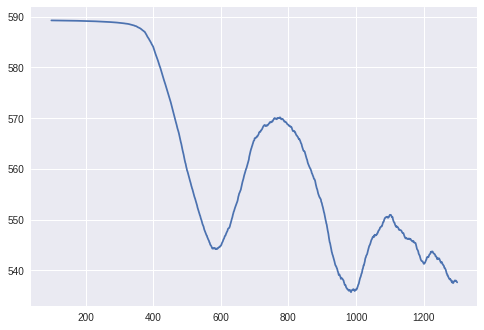

In [197]:
losses = pd.Series(losses).rolling(100).mean()

plt.plot(losses);

In [198]:
import skvideo.io
skvideo.io.vwrite("freeway.mp4", renders)

[1, 1, 1, 1, 1, 1, 1, 1]